Changelog:  (Last Updated 2023-03-09)

# Probabilistic ML: Assignment 3
- **Deadline**: 2023-03-27 (March 27th 2023)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=e3bdc4cd989bd73f9a4c90f90e39f2132bbfc67ad5378a391782e6e6fcbac8d7
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')
    
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.
    D = mean.shape[0]

    epsilon = torch.randn(num_samples, D)
    z = mean + epsilon * torch.exp(log_std)
    return z

def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a 
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)
    x, mean, log_std = x.detach().numpy(), mean.detach().numpy(), log_std.detach().numpy()
    log_pdf = torch.from_numpy(norm.logpdf(x, mean, np.exp(log_std)))
    return torch.sum(log_pdf, axis=-1)

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    D = mean.shape[0]
    samples = diag_gaussian_samples(mean, log_std, num_samples)
    logp_estimate = logprob(samples)
    logq_estimate = diag_gaussian_logpdf(samples, mean, log_std)
    return torch.sum(logp_estimate - logq_estimate) / num_samples


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.
  return -batch_elbo(log_posterior_A_beat_B_10_times_1_arg, params[0], params[1], num_samples_per_iter)

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Almost initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  7%|▋         | 55/800 [00:00<00:03, 219.07it/s]

Iteration 0 lower bound 7.9389785109362245
Iteration 25 lower bound 9.049176863148762
Iteration 50 lower bound 7.030517343345611
Iteration 75 lower bound 6.504773064012581
Iteration 100 lower bound 6.088301674363307


 30%|██▉       | 237/800 [00:00<00:01, 491.74it/s]

Iteration 125 lower bound 5.359224337356004
Iteration 150 lower bound 4.644304493740209
Iteration 175 lower bound 4.40265768188012
Iteration 200 lower bound 3.8294786720701164
Iteration 225 lower bound 3.356564339081922


 46%|████▌     | 366/800 [00:00<00:00, 572.27it/s]

Iteration 250 lower bound 3.4369538502523915
Iteration 275 lower bound 3.1316226751466685
Iteration 300 lower bound 3.4897332767763474
Iteration 325 lower bound 3.3845952743620864
Iteration 350 lower bound 3.0685765327182306
Iteration 375 lower bound 3.297761507939536


 62%|██████▏   | 494/800 [00:01<00:00, 604.05it/s]

Iteration 400 lower bound 3.213300122988303
Iteration 425 lower bound 3.096788617943631
Iteration 450 lower bound 3.183738699873113
Iteration 475 lower bound 3.1369983864009363
Iteration 500 lower bound 3.002657627990651
Iteration 525 lower bound 3.189046015291856


 78%|███████▊  | 624/800 [00:01<00:00, 625.57it/s]

Iteration 550 lower bound 3.132150105403772
Iteration 575 lower bound 3.179060274555486
Iteration 600 lower bound 3.2339222472276923
Iteration 625 lower bound 3.2036387999891174
Iteration 650 lower bound 3.084081630421743
Iteration 675 lower bound 3.335720396237077


100%|██████████| 800/800 [00:01<00:00, 519.61it/s]

Iteration 700 lower bound 2.9970118751631434
Iteration 725 lower bound 3.1251660022608103
Iteration 750 lower bound 3.170479818010181
Iteration 775 lower bound 3.249943340405983



/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


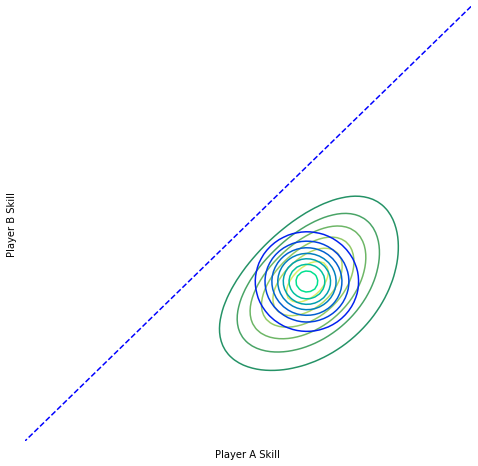

<Figure size 432x288 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std  = torch.zeros(D, requires_grad=True)
init_mean = torch.zeros(D, requires_grad=True)

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))


plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

**d) [3pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)

    return log_posterior_beat_each_other_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):
    return -batch_elbo(log_posterior_beat_each_other_10_times_1_arg, params[0], params[1], num_samples_per_iter)

**e) [3pts]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

---

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

--- 

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


 25%|██▌       | 25/100 [00:00<00:00, 245.53it/s]

Iteration 0 lower bound 27.159044138891677
Iteration 25 lower bound 24.24239422950147
Iteration 50 lower bound 20.55540518306861


100%|██████████| 100/100 [00:00<00:00, 343.72it/s]


Iteration 75 lower bound 18.617607590887346


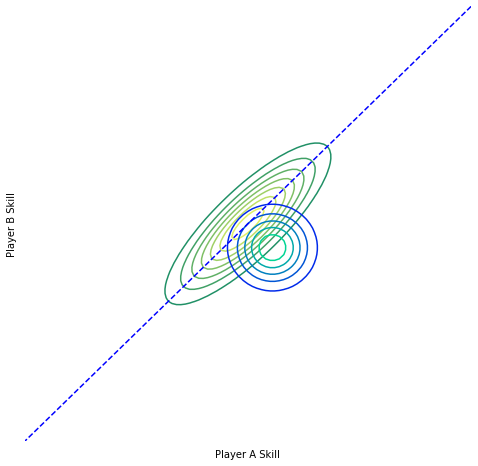

<Figure size 432x288 with 0 Axes>

In [ ]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

## 1.2 [30 pts] Approximate inference conditioned on real data 

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [ ]:
wget.download("https://michalmalyska.github.io/csc412/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
wget.download("https://michalmalyska.github.io/csc412/chess_players.csv")
names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()

games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [ ]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs] 
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [ ]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
    return -batch_elbo(log_joint_probability, params[0], params[1], num_samples_per_iter)

**c) [3pts]** Optimize, and report the final loss. 

In [ ]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

Optimizing variational parameters...


  1%|          | 3/500 [00:00<00:20, 23.75it/s]

Iteration 0 lower bound 2282.2736012285936


  6%|▌         | 31/500 [00:00<00:14, 32.10it/s]

Iteration 25 lower bound 2176.687324173708


 11%|█         | 55/500 [00:01<00:13, 32.48it/s]

Iteration 50 lower bound 2043.5111813161398


 16%|█▌        | 79/500 [00:02<00:12, 32.81it/s]

Iteration 75 lower bound 1950.145187729535


 21%|██        | 103/500 [00:03<00:12, 31.86it/s]

Iteration 100 lower bound 1875.78835922704


 26%|██▌       | 131/500 [00:04<00:11, 32.37it/s]

Iteration 125 lower bound 1825.3774995184247


 31%|███       | 155/500 [00:04<00:10, 32.25it/s]

Iteration 150 lower bound 1782.704586804444


 36%|███▌      | 179/500 [00:05<00:10, 30.43it/s]

Iteration 175 lower bound 1753.27369024902


 41%|████▏     | 207/500 [00:06<00:09, 31.17it/s]

Iteration 200 lower bound 1729.6599821024288


 46%|████▌     | 231/500 [00:07<00:08, 33.49it/s]

Iteration 225 lower bound 1707.302260333205


 51%|█████     | 255/500 [00:07<00:07, 32.47it/s]

Iteration 250 lower bound 1691.7535818161903


 56%|█████▌    | 279/500 [00:08<00:06, 31.79it/s]

Iteration 275 lower bound 1681.172798242089


 61%|██████    | 305/500 [00:09<00:09, 20.77it/s]

Iteration 300 lower bound 1675.1170432278166


 66%|██████▌   | 329/500 [00:10<00:08, 20.91it/s]

Iteration 325 lower bound 1668.2734635732754


 71%|███████   | 355/500 [00:11<00:04, 29.64it/s]

Iteration 350 lower bound 1667.0995988370234


 76%|███████▌  | 379/500 [00:12<00:03, 30.96it/s]

Iteration 375 lower bound 1664.5999603708356


 81%|████████▏ | 407/500 [00:13<00:02, 33.14it/s]

Iteration 400 lower bound 1666.4863069424493


 86%|████████▌ | 431/500 [00:14<00:02, 33.61it/s]

Iteration 425 lower bound 1666.483448197698


 91%|█████████ | 455/500 [00:14<00:01, 32.69it/s]

Iteration 450 lower bound 1669.1702367667756


 97%|█████████▋| 483/500 [00:15<00:00, 33.46it/s]

Iteration 475 lower bound 1674.749765247832


100%|██████████| 500/500 [00:16<00:00, 30.63it/s]


The final loss is approximately **1674.7464**

**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

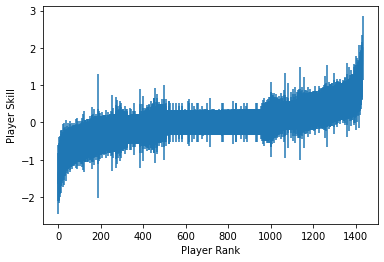

In [ ]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors

mean_skills, logstd_skills = params[0].detach(), params[1].detach()
order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[order], logstd_skills[order])

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [ ]:
for i in range(1, 11):
  print(names[order[-i]])

[1032 'doraemon61']
[311 'laode_syahril']
[640 'projetoxadrez']
[303 'mrzoom47']
[841 'cdvh']
[1431 'chesswithmom']
[1121 'hick4u1219']
[820 'smartduckduckcow']
[415 'sneaky_bugger']
[185 'lzchips']


**f) [3pt]** Plot samples from the joint posterior over the skills of lelik3310 and thebestofthebad. Based on your samples, describe in a sentence the relationship between the skills of the players. (Is one better than the other? Are they approximately even?)

[496 'lelik3310']
[512 'thebestofthebad']


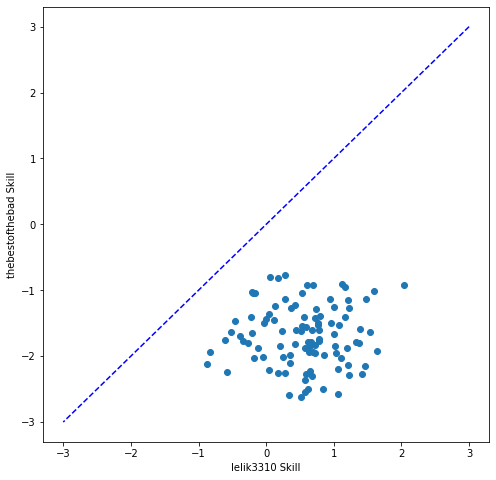

In [ ]:
lelik3310_ix = 496
thebestofthebad_ix = 512
print(names[lelik3310_ix])
print(names[thebestofthebad_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill") 
plt.ylabel("thebestofthebad Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

# TODO:  Hint:  Use plt.scatter()
plt.scatter(samples[:, lelik3310_ix], samples[:, thebestofthebad_ix])

Seems like lelik3310 is better than thebestofthebad

**g) [6pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim N (\mu, \Sigma)$, then $AX \sim  N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim N (\mu_i , \Sigma_{ii})$.

We assumed each player's skill is independent, as given here https://colab.research.google.com/drive/1-lQHWRzdNgiwBz-twqUOEsa57_ArDIy2#scrollTo=t1RKToQQcX2Q&line=14&uniqifier=1. So, 

\begin{align}
  z_A \sim N(\mu_A, \sigma^2_A) \\
  z_B \sim N(\mu_B, \sigma^2_B)
\end{align}

Let $y_A, y_B = z_A − z_B , z_B$. Then, by properties of Normal distributions, 

\begin{align}
   y_A = N(\mu_A + \mu_B, \sigma^2_A + \sigma^2_B)
\end{align}

So we have

\begin{align}
  P[z_A > z_B] &= P[z_A - z_B > 0] \\
  &= P[y_A > 0] = 1 - P[y_A \leq 0] \\
  &= 1 - \Phi(x) 
\end{align}

Where $x = \frac{\mu_A + \mu_B}{\sqrt{\sigma^2_A + \sigma^2_B}}$

**h) [4pts]** Compute the probability under your approximate posterior that lelik3310 has higher skill than thebestofthebad. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [ ]:
# TODO
def prob_A_superior_B(N, A_ix, B_ix):
    y_mu = mean_skills[A_ix] - mean_skills[B_ix]
    y_sig = torch.sqrt(torch.exp(2 * logstd_skills[A_ix]) + torch.exp(2 * logstd_skills[B_ix]))
    x = y_mu / y_sig
    formula_est = Normal(0, 1).cdf(x)

    samples = diag_gaussian_samples(mean_skills, logstd_skills, N)
    mc_est = torch.sum(samples[:, B_ix] < samples[:, A_ix]) / N

    return formula_est, mc_est

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9983937740325928
Simple MC Estimate: 0.9984999895095825


**i) [2pts]** Compute the probability that lelik3310 is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO
fifth_worst_ix = order[4]

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, fifth_worst_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9912668466567993
Simple MC Estimate: 0.9901999831199646


**j) [3 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

It would not change the answer to any of the previous 2 questions. All this does is change the prior from 0 to 10, and doesn't affect the standard deviation. So we would just be starting from another point during the training process of stochastic variational inference, and during gradient descent we would still converge to the solutions above. 

**k) [3 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Your answer here.

I suspect SVI from this assignment gives a better overall approximation. Comparing the results in this assignment to my previous assignment's results, both show that lelik3310 is a slightly better player than thebestofthebad. However, SVI shows that lelik3310 is much better than thebestofthebad. 

# 2. [50pts] Expectation-Maximization (EM) algorithm



In [ ]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 2.1 [7pts] Generating the Data

**a) [5pts]** First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = N(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. If you generate the data, you already know which sample comes from which class. Complete the following statements and run to generate.

  Hint: you can use `np.random.multivariate_normal`.

In [ ]:
num_samples = 400
cov = np.array([[10, 7], [7, 10]])
mean_1 = np.array([0.1, 0.1])
mean_2 = np.array([6.0, 0.1])

x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples // 2)
x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples // 2)
xy_class1 = np.column_stack((x_class1, np.zeros(num_samples // 2)))
xy_class2 = np.column_stack((x_class2, np.ones(num_samples // 2)))

data_full = np.vstack([xy_class1, xy_class2])
np.random.shuffle(data_full)
data = data_full[:, :2]
labels = data_full[:, 2]

**b) [2pts]** Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

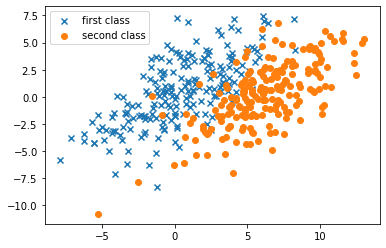

In [ ]:
plt.figure()
plt.scatter(xy_class1[:, 0], xy_class1[:, 1], marker='x', label='first class') # first class, x shape
plt.scatter(xy_class2[:, 0], xy_class2[:, 1], marker='o', label='second class') # second class, circle shape
plt.legend()
plt.show()

## 2.2 [14pts] Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat{\mu}_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat{\mu}_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost (distortion in lecture slides) vs. the number of iterations. Report your misclassification error. 

**a) [2pts]** Complete the `cost` function.

In [ ]:
def cost(data, R, Mu):
    N, D = data.shape
    K = Mu.shape[1]
    J = 0
    for i in range(K):
      J += np.dot(np.linalg.norm(data - np.array([Mu[:, i], ] * N), axis=1) ** 2, R[:, i])
    return J

**b) [4pts]** K-Means assignment step.

In [ ]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities
    """
    
    N, D = data.shape
    K = Mu.shape[1]
    r = np.zeros((N, K))

    for i in range(K):
      r[:, i] = np.linalg.norm(Mu[:, i] - data, axis=1)
    
    arg_min = np.argmin(r, axis=1)
    R_new = np.zeros((N, K))
    R_new[range(N), arg_min] = 1
    return R_new

**c) [2pts]** K-Means refitting step.

In [ ]:
# TODO: K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D = data.shape
    K = Mu.shape[1]
    Mu_new = (data.transpose() @ R) / np.sum(R, axis=0)
    return Mu_new

**d) [4pts]** Run this cell to call the K-Means algorithm.

In [ ]:
N, D = data.shape
K = 2
max_iter = 100
class_init = np.random.binomial(1., .5, size=N)
R = np.vstack([class_init, 1 - class_init]).transpose()

Mu = np.zeros([D, K])
Mu[:, 1] = 1.
R.T.dot(data), np.sum(R, axis=0)

costs = []
for it in range(max_iter):
    R = km_assignment_step(data, Mu)
    Mu = km_refitting_step(data, R, Mu)
    c = cost(data, R, Mu)
    print(it, c)
    costs.append(c)

class_1 = np.where(R[:, 0] == 1)
class_2 = np.where(R[:, 1] == 1)

0 5696.481877371974
1 5435.912784237648
2 5386.150454076671
3 5356.485033295691
4 5354.839967569702
5 5354.839967569702
6 5354.839967569702
7 5354.839967569702
8 5354.839967569702
9 5354.839967569702
10 5354.839967569702
11 5354.839967569702
12 5354.839967569702
13 5354.839967569702
14 5354.839967569702
15 5354.839967569702
16 5354.839967569702
17 5354.839967569702
18 5354.839967569702
19 5354.839967569702
20 5354.839967569702
21 5354.839967569702
22 5354.839967569702
23 5354.839967569702
24 5354.839967569702
25 5354.839967569702
26 5354.839967569702
27 5354.839967569702
28 5354.839967569702
29 5354.839967569702
30 5354.839967569702
31 5354.839967569702
32 5354.839967569702
33 5354.839967569702
34 5354.839967569702
35 5354.839967569702
36 5354.839967569702
37 5354.839967569702
38 5354.839967569702
39 5354.839967569702
40 5354.839967569702
41 5354.839967569702
42 5354.839967569702
43 5354.839967569702
44 5354.839967569702
45 5354.839967569702
46 5354.839967569702
47 5354.839967569702
48

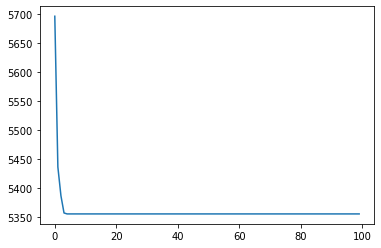

In [ ]:
plt.plot(range(max_iter), costs)

In [ ]:
missclassification_error = np.sum(R[:, 0] == labels) / N
print(f'Missclassification error: {missclassification_error}')

Missclassification error: 0.2475


**e) [2pts]** Make a scatterplot for the data points showing the K-Means cluster assignments of each point.


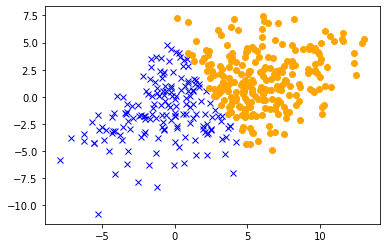

In [ ]:
plt.plot(data[class_1, 0], data[class_1, 1], 'x', color='blue') # first class, x shape
plt.plot(data[class_2, 0], data[class_2, 1], 'o', color='orange') # second class, circle shape
plt.show()

## 2.3 [21pts] Implement EM algorithm for Gaussian mixtures

Next, implement the EM algorithm for Gaussian mixtures. Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  - Identify the correct arguments, and the order to run them.
  - Initialize the algorithm with the same initialization as in Q2.1 for the means, and with $\hat\Sigma_1=\hat\Sigma_2=I$, and $\hat\pi_1=\hat\pi_2$ for the covariances.
    
Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both. Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [ ]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

**a) [5pts]** Log-Likelihood.

In [ ]:
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """
    N, D = data.shape  # Number of datapoints and dimension of datapoint
    K = len(Pi) # number of mixtures
    L, T = 0., 0.
    # given n, k, compute the likelihood from the k-th Gaussian weighted by the mixing coefficients
    for n in range(N):
      for k in range(K):
        T = Pi[k] * normal_density(data[n], Mu[:, k], Sigma[k])
      L += np.log(T)
    return L

**b) [5pts]** Gaussian Mixture Expectation Step.

In [ ]:
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        Gamma: a NxK matrix of responsibilities 
    """
    N, D = data.shape # Number of datapoints and dimension of datapoint
    K = len(Pi) # number of mixtures
    Gamma = np.zeros((N, K)) # zeros of shape (N,K), matrix of responsibilities

    # given n, k, normalize by sum across second dimension (mixtures)
    for n in range(N):
      for k in range(K):
        Gamma[n, k] = Pi[k] * normal_density(data[n], Mu[:, k], Sigma[k])
      Gamma[n] /= np.sum(Gamma[n])

    return Gamma

**c) [5pts]** Gaussian Mixture Maximization Step.

In [ ]:
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: a NxD matrix for the data points
        Gamma: a NxK matrix of responsibilities 
    
    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """
    N, D = data.shape # Number of datapoints and dimension of datapoint
    K = Gamma.shape[1]  # number of mixtures
    Nk = np.sum(Gamma, axis=0) # Sum along first axis 
    Mu = (data.T @ Gamma) / Nk
    Sigma = np.zeros((K, D, D))

    # fill in Sigma[k] for each k
    for k in range(K):
      diff = data - Mu[:, k]
      x = np.eye(N) * Gamma[:, k]
      Sigma[k] = np.einsum('ji,jj,jk->ik', diff, x, diff) / Nk[k]

    Pi = Nk / N
    return Mu, Sigma, Pi

**d) [4pts]** Run this cell to call the Gaussian Mixture EM algorithm.

In [ ]:
N, D = data.shape
K = 2 
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K
Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

max_iter  = 200

logs = []
for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi)
    Mu, Sigma, Pi = gm_m_step(data, Gamma)
    l = log_likelihood(data, Mu, Sigma, Pi)
    print(f'{it}:, {l}')
    logs.append(l)

class_1 = np.where(Gamma[:, 0] >= .5)
class_2 = np.where(Gamma[:, 1] >= .5)

0:, -2478.0111321185236
1:, -2416.9962879477416
2:, -2386.1844061020142
3:, -2367.06257440021
4:, -2353.8780531596753
5:, -2344.202111062124
6:, -2336.832061176782
7:, -2331.1169156511805
8:, -2326.6921271676847
9:, -2323.360781397813
10:, -2321.0353509125976
11:, -2319.706903716702
12:, -2319.4265924657175
13:, -2320.289083824941
14:, -2322.4051347392724
15:, -2325.847433073803
16:, -2330.568798403676
17:, -2336.337906224176
18:, -2342.763045067012
19:, -2349.4054511150766
20:, -2355.8958568399607
21:, -2361.9894131839815
22:, -2367.5675797150743
23:, -2372.614361375462
24:, -2377.181212335876
25:, -2381.3516401391375
26:, -2385.2146016459783
27:, -2388.849419142811
28:, -2392.3199376661073
29:, -2395.67423223463
30:, -2398.946860567377
31:, -2402.1618290299775
32:, -2405.335374666474
33:, -2408.4782341581135
34:, -2411.597356917927
35:, -2414.6971371140144
36:, -2417.780270781585
37:, -2420.848337964947
38:, -2423.902190988975
39:, -2426.942209777771
40:, -2429.968467870796
41:, -243

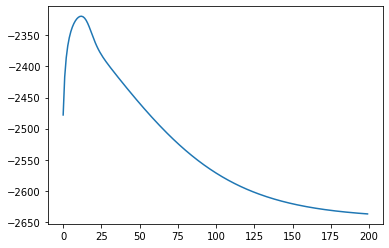

In [ ]:
plt.plot(range(max_iter), logs)

In [ ]:
missclassification_error = np.sum((Gamma[:, 0] >= 0.5) == labels) / N
print(f'Missclassification error: {missclassification_error}')

Missclassification error: 0.1175


**e) [2pts]** Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point

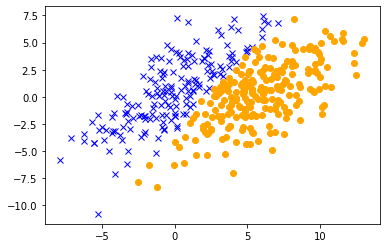

In [ ]:
plt.plot(data[class_1, 0], data[class_1, 1], 'x', color='blue') # first class, x shape
plt.plot(data[class_2, 0], data[class_2, 1], 'o', color='orange') # second class, circle shape
plt.show()

## 2.4 [8pts] Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments. [2pts]
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method? [2pts]
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data? [3pts]
* Comment on what might happen as you increase the number $K$ of clusters. [1pts]
 


Your answer here.

- The k-Means algorithm had a missclassification rate of 0.2475 while EM had a rate of 0.1175. So EM performed better. Also, visually it looks closer to the original.
- Looks like k-Means converges faster than EM algorithm. 
- Missclassification error results (k-means, EM):
  1. (0.265, 0.105)
  2. (0.25, 0.1075)
  3. (0.265, 0.085)
  4. (0.2625, 0.0975)
  5. (0.265, 0.485)

- In 4/5 trials, EM had a lower missclassification rate than k-means. So it seems that for some realizations of data, it is possible for EM to perform worse than k-Means. K-means seems to hover around 0.265 error rate and EM tends to hover around 0.1, except for on the last trial.
- If we were to increase the number of clusters, it could increase or decrease the missclassification rate of both algorithms. For EM, it could also be possible that the algorithm converges to a local minimum instead of a global minimum, becoming stuck at a suboptimal solution. 

In [ ]:
def generate_data():
  num_samples = 400
  cov = np.array([[10, 7], [7, 10]])
  mean_1 = np.array([0.1, 0.1])
  mean_2 = np.array([6.0, 0.1])

  x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples // 2)
  x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples // 2)
  xy_class1 = np.column_stack((x_class1, np.zeros(num_samples // 2)))
  xy_class2 = np.column_stack((x_class2, np.ones(num_samples // 2)))

  data_full = np.vstack([xy_class1, xy_class2])
  np.random.shuffle(data_full)
  data = data_full[:, :2]
  labels = data_full[:, 2]
  return data, labels

def run_kmeans(data, labels):
  N, D = data.shape
  K = 2
  max_iter = 100
  class_init = np.random.binomial(1., .5, size=N)
  R = np.vstack([class_init, 1 - class_init]).transpose()

  Mu = np.zeros([D, K])
  Mu[:, 1] = 1.
  R.T.dot(data), np.sum(R, axis=0)

  costs = []
  for it in range(max_iter):
      R = km_assignment_step(data, Mu)
      Mu = km_refitting_step(data, R, Mu)
      c = cost(data, R, Mu)
      costs.append(c)

  class_1 = np.where(R[:, 0] == 1)
  class_2 = np.where(R[:, 1] == 1)

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
  axes[0].plot(range(max_iter), costs)

  missclassification_error = np.sum(R[:, 0] == labels) / N
  print(f'k-means Missclassification error: {missclassification_error}')

  axes[1].plot(data[class_1, 0], data[class_1, 1], 'x', color='blue') # first class, x shape
  axes[1].plot(data[class_2, 0], data[class_2, 1], 'o', color='orange') # second class, circle shape
  fig.suptitle('K means results')
  fig.tight_layout()

def run_EM(data, labels):
  N, D = data.shape
  K = 2 
  Mu = np.zeros([D, K])
  Mu[:, 1] = 1.
  Sigma = [np.eye(2), np.eye(2)]
  Pi = np.ones(K) / K
  Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

  max_iter  = 200

  logs = []
  for it in range(max_iter):
      Gamma = gm_e_step(data, Mu, Sigma, Pi)
      Mu, Sigma, Pi = gm_m_step(data, Gamma)
      l = log_likelihood(data, Mu, Sigma, Pi)
      logs.append(l)

  class_1 = np.where(Gamma[:, 0] >= .5)
  class_2 = np.where(Gamma[:, 1] >= .5)

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
  axes[0].plot(range(max_iter), logs)

  missclassification_error = np.sum((Gamma[:, 0] >= 0.5) == labels) / N
  print(f'EM Missclassification error: {missclassification_error}')

  axes[1].plot(data[class_1, 0], data[class_1, 1], 'x', color='blue') # first class, x shape
  axes[1].plot(data[class_2, 0], data[class_2, 1], 'o', color='orange') # second class, circle shape
  fig.suptitle('EM results')
  fig.tight_layout()

First run

k-means Missclassification error: 0.265
EM Missclassification error: 0.105


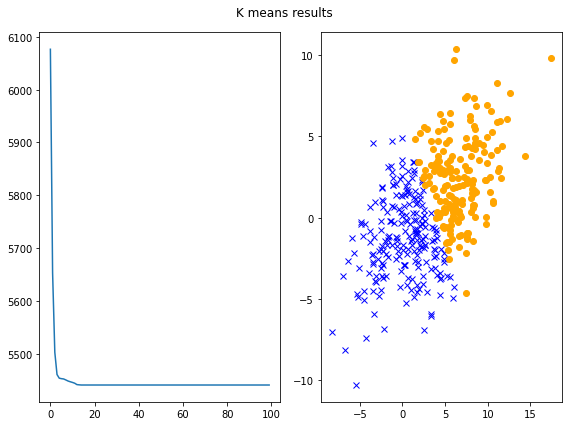

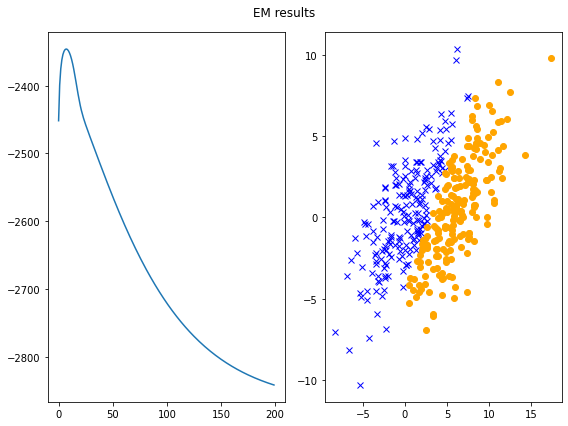

In [ ]:
data, labels = generate_data()
run_kmeans(data, labels)
run_EM(data, labels)

Second Run

k-means Missclassification error: 0.25
EM Missclassification error: 0.1075


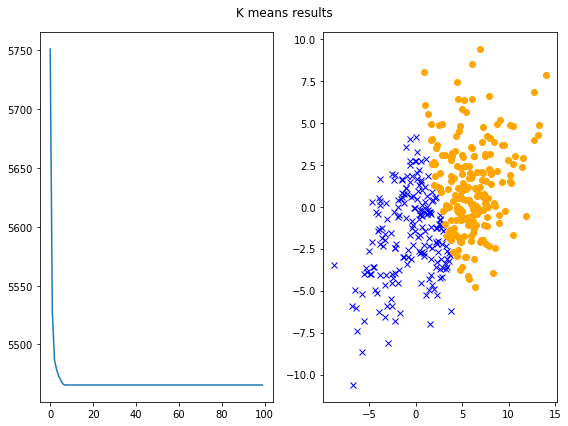

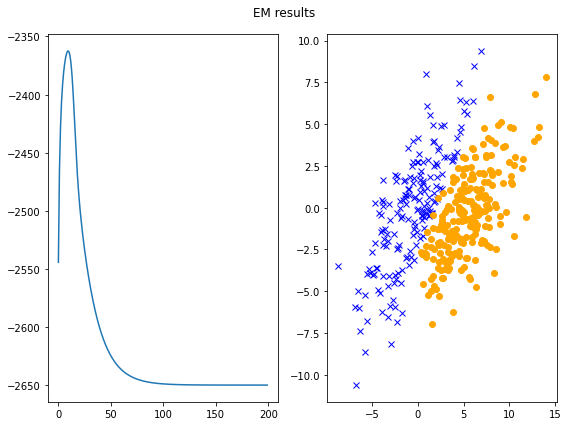

In [ ]:
data, labels = generate_data()
run_kmeans(data, labels)
run_EM(data, labels)

Third run

k-means Missclassification error: 0.265
EM Missclassification error: 0.085


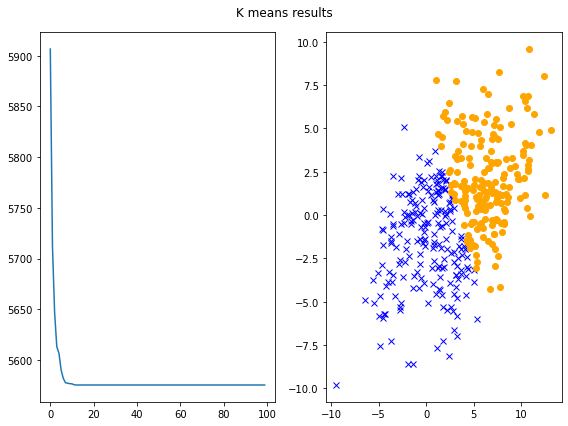

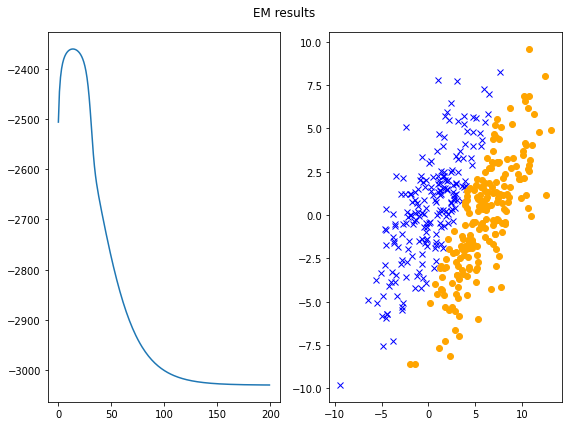

In [ ]:
data, labels = generate_data()
run_kmeans(data, labels)
run_EM(data, labels)

Fourth run

k-means Missclassification error: 0.2625
EM Missclassification error: 0.0975


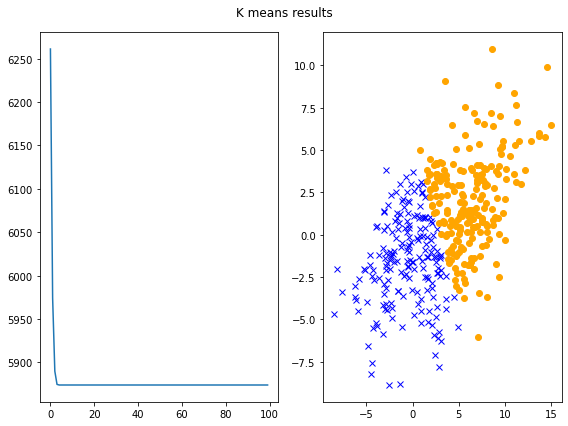

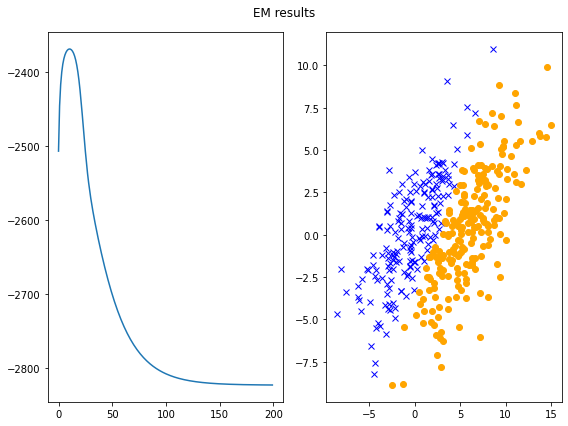

In [ ]:
data, labels = generate_data()
run_kmeans(data, labels)
run_EM(data, labels)

Fifth run

k-means Missclassification error: 0.265
EM Missclassification error: 0.485


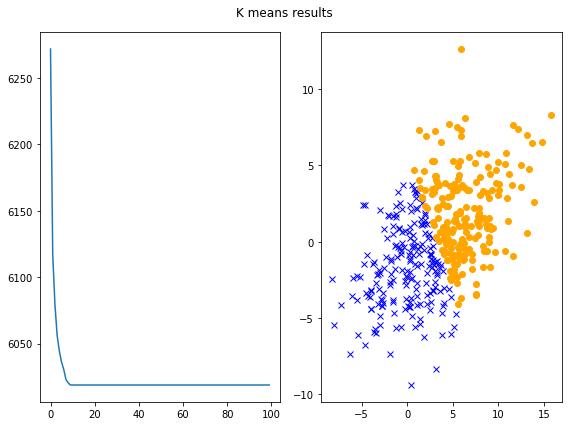

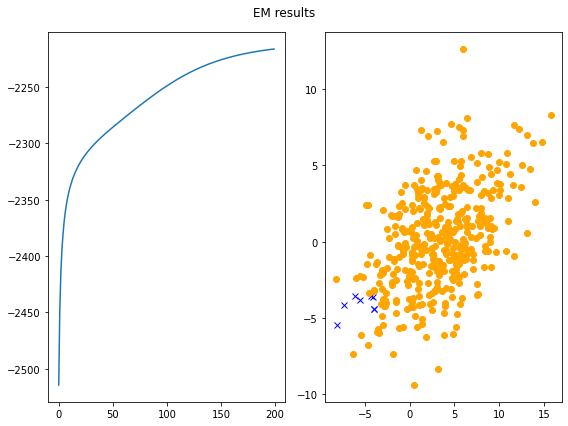

In [ ]:
data, labels = generate_data()
run_kmeans(data, labels)
run_EM(data, labels)